# Проект Рекомендация тарифов

<b>Цели проекта.</b><br>

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».<br>

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.<br>

Постройте модель с максимально большим значением accuracy. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до $0.75$. Проверьте <i>accuracy</i> на тестовой выборке самостоятельно.

<b>Описание тарифов.</b><br>

Тариф <i>«Смарт»</i>
1. Ежемесячная плата: $550$ рублей
2. Включено $500$ минут разговора, $50$ сообщений и $15$ Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета: 
    - Минута разговора — $3$ рубля. Количество использованных минут и мегабайтов «Мегалайн» всегда округляет вверх. Если пользователь проговорил всего $1$ секунду, в тарифе засчитывается целая минута.
    - Сообщение — $3$ рубля.
    - $1$ Гб интернет-трафика — $200$ рублей.

Тариф <i>«Ультра»</i>
1.	Ежемесячная плата: $1,950$ рублей
2.	Включено $3,000$ минут разговора, $1,000$ сообщений и $30$ Гб интернет-трафика
3.	Стоимость услуг сверх тарифного пакета: 
    - Минута разговора — $1$ рубль;
    - Сообщение — $1$ рубль;
    - $1$ Гб интернет-трафика: $150$ рублей.

## Настройка проекта.

### Импорт необходимых для исследования библиотек, модулей, классов и функций.

In [1]:
# Importing entire libraries with aliases
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import json
import warnings
try:
    import psutil
    IS_PSUTIL = True
except ImportError:
    IS_PSUTIL = False
import os

# Importing specific modules from libraries with aliases or not
from joblib import dump, load
from matplotlib import pyplot as plt
from scipy import stats as st
from matplotlib.colors import ListedColormap

# Importing specific functions from libraries from sklearn
from sklearn.metrics import accuracy_score, mean_squared_error, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

from sklearn.model_selection import StratifiedShuffleSplit

# Importing specific models from sklearn that are necessary for analysis
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

### Оптимизация отображения.

Снимем ограничения вывода на экран и оставляем привычные два знака после запятой и пр.

In [2]:
# Display options for pandas DataFrame objects
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:,.2f}'.format
warnings.simplefilter('ignore')

### Используемые пользовательские функции и глобальные переменные.

>RANDOM_STATE - это параметр, который используется для управления генерацией псевдослучайных чисел в различных функциях и алгоритмах, которые имеют элемент случайности в своей работе.<br><br>Когда мы используем RANDOM_STATE, мы фиксируем "зерно" генератора псевдослучайных чисел, которое гарантирует, что при каждом запуске программы будут генерироваться одни и те же псевдослучайные числа. Это позволяет нам повторять результаты экспериментов и упрощает отладку программ.<br><br>RANDOM_STATE может использоваться во многих функциях и алгоритмах, таких как разбиение данных на обучающую и тестовую выборки, инициализация весов в некоторых моделях машинного обучения, случайный выбор гиперпараметров и т.д.

In [3]:
RANDOM_STATE = 42
CIVIDIS = False

Странно, но факт. На значении равном $12,345$ результаты получаются глаже...

#### Безопасная загрузка данных из одного из возможных источников с обработкой исключений и оптимизацией.

In [4]:
# Safe loading of data from one of the possible sources with exception handling and optimization
# filename_dict - Dictionary that maps different locations to file paths or URLs

def my_read_csv(filename_dict={}, logfile=None):

    # Importing specific functions or classes from modules that are required for safe file reading
    import sys
    from requests import head
    from io import StringIO
    from urllib.request import urlopen
    from csv import Sniffer; sniff = Sniffer().sniff # Creating an alias for a specific method from a class
    from os.path import isfile
    from os.path import abspath
    from os.path import basename

    if logfile != None:
        # Save the standard output stream in a variable
        _stdout_orig = sys.stdout
        # Open the log file for writing
        _log_file = open(logfile, 'w')
        # Redirect the standard output stream to the log file
        sys.stdout = _log_file

    # Check if file exists in local file system (isfile() from os.path)
    if isfile(filename_dict.get('local')):
        print('File exists locally')
        _loc = 'local'
    # Check if file exists on Practicum platform (isfile() from os.path)
    elif isfile(filename_dict.get('practicum')):
        print('File exists on Practicum')
        _loc = 'practicum'
    # Check if file exists on Yandex server (head() from requests)
    elif head(filename_dict.get('ya')).status_code == 200:
        print('File exists on Yandex server')
        _loc = 'ya'
    # Raise error if file not found in any location
    else:
        if logfile != None:
            # Restore the standard output stream
            sys.stdout = _stdout_orig
            # Don't forget to close the file after finishing the work
            _log_file.close()
        raise RuntimeError('Something went wrong while finding the file.')

    # Get filename based on location
    _filename = filename_dict.get(_loc)
    if _loc != 'ya':
        print(f'Absolute file name: \'{abspath(_filename)}\'')
    else:
        print(f'Absolute file name: \'{_filename}\'')

    # Determine delimiter used in CSV file
    if _loc != 'ya':
        try:
            # Open file and read first 1024 bytes to determine delimiter (sniff() from csv Sniffer())
            with open(_filename, 'r', encoding='utf-8') as _csvfile:
                _dialect = sniff(_csvfile.read(1024))
                print(f'Most likely delimiter in the file: \'{_dialect.delimiter}\'')
        except Exception:
            if logfile != None:
                # Restore the standard output stream
                sys.stdout = _stdout_orig
                # Don't forget to close the file after finishing the work
                _log_file.close()
            raise RuntimeError('Something went wrong while opening the local|practicum file for delimiter analysis')
    else:
        try:
            # Open URL and read first 1024 bytes to determine delimiter (urlopen() from urllib.request)
            _response = urlopen(_filename)
            # Creating file-like object (StringIO() from io)
            _csvfile = StringIO()
            # Writing the content of the variable _csvfile to the object
            _csvfile.write(_response.read().decode('utf-8'))
            # Moving the cursor to the beginning of the file
            _csvfile.seek(0)
            # Now _csvfile can be used as an opened file
            _dialect = sniff(_csvfile.read(1024))
            print(f'Most likely delimiter in the file: \'{_dialect.delimiter}\'')
        except Exception:
            if logfile != None:
                # Restore the standard output stream
                sys.stdout = _stdout_orig
                # Don't forget to close the file after finishing the work
                _log_file.close()
            raise RuntimeError('Something went wrong while opening the url file for delimiter analysis')

    # Read the first (for example) line of the file
    if _loc != 'ya':
        with open(_filename, 'r', encoding='utf-8') as _csvfile:
            for i, line in enumerate(_csvfile):
                if i == 0:
                    print('The first line of the file:')
                    print(line.rstrip('\n'))
                    break
    else:
        # Moving the cursor to the beginning of the file
        _csvfile.seek(0)
        for i, line in enumerate(_csvfile):
            if i == 0:
                print('The first line of the file:')
                print(line.rstrip('\n'))
                break
        # Closing the file-like object
        _csvfile.close()

    # Read CSV file into pandas DataFrame
    try:
        # Load CSV into pandas DataFrame using the appropriate delimiter
        _df = pd.read_csv(_filename, \
                          sep=_dialect.delimiter, \
                          dtype=None)
        print(f'CSV Data loaded into pandas DataFrame from \'{_loc}\'')
        if _loc == 'ya':
            _df.to_csv(basename(_filename), index=False)
            print(f'CSV saved from \'ya\' to a local file in the current directory: {basename(_filename)}')
    except Exception:
        if logfile != None:
            # Restore the standard output stream
            sys.stdout = _stdout_orig
            # Don't forget to close the file after finishing the work
            _log_file.close()
        raise RuntimeError('Something went wrong while opening the file as a CSV')

    # The total size of the DataFrame in kbytes
    # Sizes in bytes for each column summed
    # Total size in kbytes
    _total_memory_usage_kb = (_df.memory_usage(deep=True).sum() + \
                              _df.index.memory_usage() + \
                              _df.columns.memory_usage()) / 1024
    print(f'Deep memory usage of the original DataFrame: {_total_memory_usage_kb:.2f} KB')

    # Iterate over each column and convert values to the desired data type
    for col in _df.columns:
        if _df[col].dtype == 'float64':
            _dumb = True
            #_df[col] = _df[col].astype(np.float16)
            #print(f'The column \'{col}\' has been converted from the \'float64\' type to the \'np.float16\' type')
        elif _df[col].dtype == 'int64':
            _df[col] = _df[col].astype(np.int16)
            print(f'The column \'{col}\' has been converted from the \'int64\' type to the \'np.int16\' type')
        #elif _df[col].dtype == 'object':
            #_df[col] = _df[col].astype('category')    

    _total_memory_usage_kb_opt = (_df.memory_usage(deep=True).sum() + \
                                  _df.index.memory_usage() + \
                                  _df.columns.memory_usage()) / 1024
    print(f'Deep memory usage of the optimized DataFrame: {_total_memory_usage_kb_opt:.2f} KB')
    print(f'Memory saving: {(_total_memory_usage_kb - _total_memory_usage_kb_opt):.2f} KB')

    if logfile != None:
        # Restore the standard output stream
        sys.stdout = _stdout_orig
        # Don't forget to close the file after finishing the work
        _log_file.close()

    return _df

#### Правило Стерджеса.

In [5]:
# Custom function for Sturges-like rule
def my_sturges(n=1000):
    return 1 + int(3.322*np.log(n))
#   return 1 + int(3.322*np.log10(n))

#### Сохранение построенных графиков.

In [6]:
def my_save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    
    import os
    
    # Set the path to save images
    _IMAGES_PATH = ''
    
    # Join the filename and extension to create the full path for saving the image
    _path = os.path.join(_IMAGES_PATH, fig_id + '.' + fig_extension)
    
    # Print a message indicating that the figure is being saved
    print('Saving figure', fig_id)
    
    # Adjust the subplot parameters to make the plot fit nicely in the figure
    if tight_layout:
        plt.tight_layout()
    
    # Save the figure to a file
    plt.savefig(_path, format=fig_extension, dpi=resolution)

#### Confusion Matrix.

In [7]:
def my_confusion_matrix(model=None, target=None, predictions=None):
    global CIVIDIS
    _model_name = model.__class__.__name__
    _cmap = ListedColormap(sns.color_palette('cividis', n_colors=256).as_hex()) if CIVIDIS else 'Blues'

    _fig, _ax = plt.subplots(figsize=(4, 3))

    _fig.suptitle(f'Confusion matrix для {_model_name}')

    sns.heatmap(confusion_matrix(target, predictions, normalize='all'), \
                cmap=_cmap , \
                annot=True, \
                fmt='.2f', \
                ax=_ax, \
                vmin=0 if CIVIDIS else None, \
                vmax=1 if CIVIDIS else None)

    plt.tight_layout()
    plt.xlabel('Predicted')
    plt.ylabel('True')
    #my_save_fig(_model_name + '_confusion_matrix_plots')
    plt.show()

#### ROC Анализ и Precision-Recall Анализ.

In [8]:
def my_analyze_classification_performance(model=None, dummy=None, target=None, features=None):
    # Getting model name
    _model_name = model.__class__.__name__
    
    # Getting the probabilities of belonging to class 1 on the validation set
    _target_train_pred_prob = model.predict_proba(features)[:, 1]
    if dummy!= None:
        _target_train_pred_prob_dummy = dummy.predict_proba(features)[:, 1]

    _fig, _ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    _fig.suptitle(f'Производительность модели классификации {_model_name}')

    # Calculating the values of fpr, tpr, and thresholds for ROC curve construction
    _fpr, _tpr, _thresholds = roc_curve(target, _target_train_pred_prob)
    if dummy != None:
        _fpr_dummy, _tpr_dummy, _thresholds_dummy = roc_curve(target, _target_train_pred_prob_dummy)

    # Calculating the value of AUC-ROC to evaluate the model quality
    _auc_roc = roc_auc_score(target, _target_train_pred_prob)
    if dummy != None:
        _auc_roc_dummy = roc_auc_score(target, _target_train_pred_prob_dummy)

    # Plotting the ROC curve
    _ax[0].plot(_fpr, _tpr, color='SteelBlue', label='ROC Curve')
    if dummy != None:
        _ax[0].plot(_fpr_dummy, _tpr_dummy, '--', color='DarkRed', label=('Dummy ' + dummy.strategy))
    else:
        _ax[0].plot([0, 1], [0, 1], '--', color='DarkRed', label='Random Guess')
    _ax[0].legend(loc='lower right')
    if dummy != None:
        _ax[0].set_title(f'ROC curve (AUC = {_auc_roc:.3f})\nDummy {dummy.strategy} AUC = {_auc_roc_dummy:.3f}')
    else:
        _ax[0].set_title(f'ROC curve (AUC = {_auc_roc:.3f})')
    _ax[0].set_xlabel('False Positive Rate')
    _ax[0].set_ylabel('True Positive Rate')
    _ax[0].grid(True)


    # Calculating the values of precision and recall for PR curve construction
    _precision, _recall, _thresholds = precision_recall_curve(target, _target_train_pred_prob)
    if dummy != None:
        _precision_dummy, _recall_dummy, _thresholds_dummy = precision_recall_curve(target, _target_train_pred_prob_dummy)

    # Calculating the value of AUC-PR to evaluate the model quality
    _auc_pr = average_precision_score(target, _target_train_pred_prob)
    if dummy != None:
        _auc_pr_dummy = average_precision_score(target, _target_train_pred_prob_dummy)

    # Plotting the PR curve
    _ax[1].plot(_recall, _precision, color='SteelBlue', label='Precision-Recall Curve')
    if dummy != None:
        _ax[1].plot(_recall_dummy, _precision_dummy, '--', color='DarkRed', label=('Dummy ' + dummy.strategy))
    else:
        _ax[1].plot([0, 1], [1, 0], '--', color='DarkRed', label='Random Guess')
    _ax[1].legend(loc='lower left')
    if dummy != None:
        _ax[1].set_title(f'Precision-Recall curve (AUC = {_auc_pr:.3f})\nDummy {dummy.strategy} AUC = {_auc_pr_dummy:.3f}')
    else:
        _ax[1].set_title(f'Precision-Recall curve (AUC = {_auc_pr:.3f})')
    _ax[1].set_xlabel('Recall')
    _ax[1].set_ylabel('Precision')
    _ax[1].grid(True)

    # Optimization of the layout of the elements
    plt.tight_layout()
    
    # Saving the current figure to a file with the specified name
    #my_save_fig(_model_name + '_roc_pr_plots')
    
    # Displaying a plot on the screen
    plt.show()

## Загрузка данных.

Безопасная загрузка данных из одного из возможных источников с обработкой exceptions.
Сепаратор определяется автоматически.
Для оптимизации использования оперативной памяти производится автоматическое преобразование типов.

In [9]:
filename_dict = {'local': 'users_behavior.csv', \
                 'practicum': '/datasets/users_behavior.csv', \
                 'ya': 'https://code.s3.yandex.net/datasets/users_behavior.csv'}
users_behavior = my_read_csv(filename_dict, logfile='my_read_csv.log')

In [10]:
with open('my_read_csv.log', 'r') as logfile:
    print(logfile.read())

File exists locally
Absolute file name: 'C:\Users\dmitr\OneDrive\Документы\DS Yandex\СПРИНТ 9 из 23 Введение в машинное обучение\ПРОЕКТ - Введение в машинное обучение\users_behavior.csv'
Most likely delimiter in the file: ','
The first line of the file:
calls,minutes,messages,mb_used,is_ultra
CSV Data loaded into pandas DataFrame from 'local'
Deep memory usage of the original DataFrame: 126.00 KB
The column 'is_ultra' has been converted from the 'int64' type to the 'np.int16' type
Deep memory usage of the optimized DataFrame: 107.17 KB
Memory saving: 18.83 KB



## Общая информация о данных.

### Описание данных.

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
- `сalls` — количество звонков,
- `minutes` — суммарная длительность звонков в минутах,
- `messages` — количество sms-сообщений,
- `mb_used` — израсходованный интернет-трафик в Мб,
- `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — $1$, «Смарт» — $0$).


### Предварительное исследование данных.

In [11]:
users_behavior.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.00,311.90,83.00,"19,915.42",0
1,85.00,516.75,56.00,"22,696.96",0
2,77.00,467.66,86.00,"21,060.45",0
3,106.00,745.53,81.00,"8,437.39",1
4,66.00,418.74,1.00,"14,502.75",0


Количество звонков и сообщений по логике должны быть целочисленными. Приведём их к `np.int16`.

In [12]:
users_behavior[['calls', 'messages']] = users_behavior[['calls', 'messages']].astype(np.int16)

In [13]:
users_behavior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   int16  
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   int16  
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int16  
dtypes: float64(2), int16(3)
memory usage: 69.2 KB


Пропусков нет.

In [14]:
users_behavior.describe()

,calls,minutes,messages,mb_used,is_ultra
count,"3,214.00","3,214.00","3,214.00","3,214.00","3,214.00"
mean,63.04,438.21,38.28,"17,207.67",0.31
std,33.24,234.57,36.15,"7,570.97",0.46
min,0.00,0.00,0.00,0.00,0.00
25%,40.00,274.58,9.00,"12,491.90",0.00
50%,62.00,430.60,30.00,"16,943.24",0.00
75%,82.00,571.93,57.00,"21,424.70",1.00
max,244.00,"1,632.06",224.00,"49,745.73",1.00


Рассмотрим смещение распределения признаков.

>Функция st.skew() является методом библиотеки scipy.stats и используется для вычисления коэффициента асимметрии выборки. Коэффициент асимметрии показывает, насколько сильно выборка отличается от симметричного распределения.<br><br>
>Если коэффициент асимметрии равен $0$, то выборка симметрична. Если коэффициент асимметрии больше $0$, то это означает, что выборка имеет длинный "хвост" вправо, то есть содержит более высокие значения, чем среднее. Если коэффициент асимметрии меньше $0$, то это означает, что выборка имеет длинный "хвост" влево, то есть содержит более низкие значения, чем среднее.

In [15]:
for col in users_behavior.columns:
    print(f'Коэффициент асимметрии признака {col}: {st.skew(users_behavior[col]):.1f}')

Коэффициент асимметрии признака calls: 0.6
Коэффициент асимметрии признака minutes: 0.6
Коэффициент асимметрии признака messages: 1.3
Коэффициент асимметрии признака mb_used: 0.4
Коэффициент асимметрии признака is_ultra: 0.8


Все данные имеют положительное смещение вправо особенно заметное на признаке `messages`.

Посмотрим на гистограммы признаков и класса (`is_ultra`).

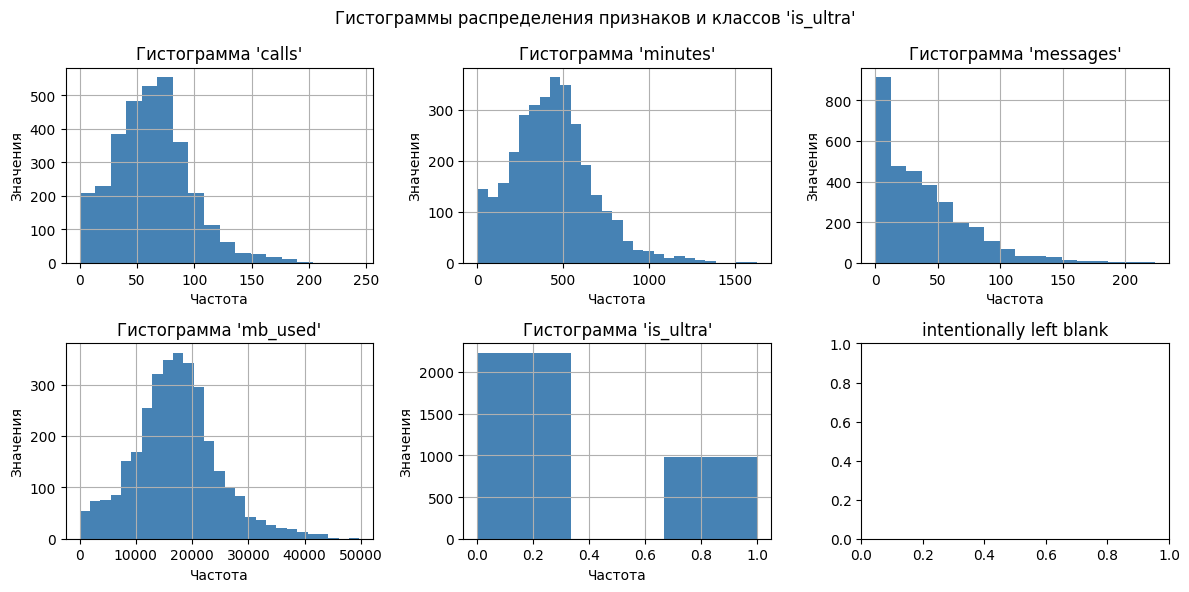

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))

fig.suptitle('Гистограммы распределения признаков и классов \'is_ultra\'')

for i, ax in enumerate(axes.flat):
    if i >= len(users_behavior.columns):
        ax.set_title(f'intentionally left blank')
    else:
        ax.hist(users_behavior.iloc[:, i], \
                bins=my_sturges(users_behavior.iloc[:, i].nunique()), \
                color='SteelBlue')
        ax.set_title(f'Гистограмма \'{users_behavior.columns[i]}\'')
        ax.set_xlabel('Частота')
        ax.set_ylabel('Значения')
        ax.grid(True)

plt.tight_layout()

#my_save_fig('attribute_histogram_plots')

plt.show()

Многие гистограммы имеют медленно убывающие хвосты. Есть выбросы в нуле. Это может несколько затруднить некоторым алгоритмам МО выявлять паттерны. Наблюдается сильная разбалансированность класса `is_ultra` с соотношением $0.44$:

In [17]:
round((users_behavior['is_ultra'] == 1).mean() / (users_behavior['is_ultra'] == 0).mean(), 2)

0.44

>Если у нас есть $100$ объектов класса $A$ и $1000$ объектов класса $B$, то их отношение составит $0,1$. Если это число меньше $0,5$, то класс считается сильно разбалансированным. Если число между $0,5$ и $1$, то класс считается умеренно разбалансированным. Если же число равно $1$, то класс считается сбалансированным.<br><br>
>При работе с разбалансированными классами следует использовать модели, способные справляться с этой проблемой. Некоторые из наиболее популярных моделей для классификации разбалансированных классов включают:
>- Logistic Regression with regularization (L1, L2) с балансировкой классов
>- Decision Trees с балансировкой классов
>- Random Forest с балансировкой классов или весом класса
>- Gradient Boosting с балансировкой классов или весом класса
>- Support Vector Machines с балансировкой классов или весом класса
>- Neural Networks со специальными слоями для обработки разбалансированных классов (class weighting layer, spatial attention layer).

Посмотрим корреляции между признаками объектов.

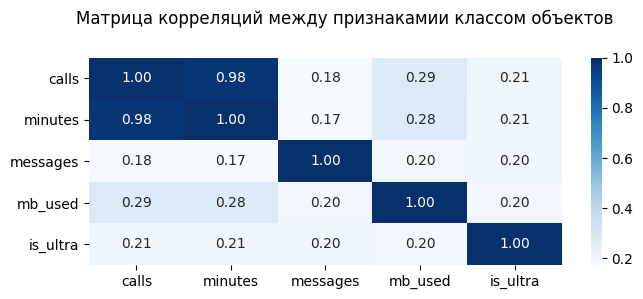

In [18]:
cmap = ListedColormap(sns.color_palette('cividis', n_colors=256).as_hex()) if CIVIDIS else 'Blues'

fig, ax = plt.subplots(figsize=(7, 3))

fig.suptitle('Матрица корреляций между признакамии классом объектов')

sns.heatmap(users_behavior.corr(), \
            cmap=cmap , \
            annot=True, \
            fmt='.2f', \
            ax=ax, \
            vmin=0 if CIVIDIS else None, \
            vmax=1)

plt.tight_layout()

#my_save_fig('attributes_correlation_plots')

plt.show()

Между признаками `calls` и `minutes` имеется очень высокая корреляция. В остальных признаках наблюдается очень слабая корреляция, которая, тем не менее, накладывает ограничение на использование, например, такой модели как Наивный байесовский классификатор (Naive Bayes Classifier).

>Наивный байесовский классификатор (Naive Bayes Classifier) - это простой и эффективный алгоритм классификации, основанный на теореме Байеса с предположением о независимости между признаками. В качестве вероятностной модели используется распределение Бернулли, мультиномиальное распределение или распределение Гаусса.<br><br>
>Наивный байесовский классификатор может быть очень эффективным при работе с большими наборами данных, особенно в тех случаях, когда количество признаков очень велико. Он также может хорошо работать с категориальными данными и может быть использован для классификации текстовых данных.<br><br>
>Однако, стоит учитывать, что наивный байесовский классификатор не всегда является наилучшим выбором, особенно если данные не соответствуют предположению о независимости между признаками. В таких случаях лучше рассмотреть другие алгоритмы, например, деревья решений, случайный лес или градиентный бустинг.

### Краткий вывод.

Данные сгруппированы, без пропусков и имеют положительное смещение вправо особенно заметное на признаке `messages`. Распределения многих признаков имеют медленно убывающие хвосты и имеют выбросы в нуле, что может несколько затруднить некоторым алгоритмам МО выявлять паттерны. Наблюдается сильная разбалансированность класса `is_ultra` с соотношением  $0.44$. При работе с разбалансированными классами следует использовать модели, способные справляться с этой проблемой. Между признаками `calls` и `minutes` имеется очень высокая корреляция. В остальных признаках наблюдается очень слабая корреляция, которая, тем не менее, также накладывает ограничение на использование некоторых моделей.

## Разделение данных на выборки.

Вспомним, что в нашем датасете есть дисбаланс классов, в этом случае лучше использовать функцию `split()` класса `StratifiedShuffleSplit()` из библиотеки `sklearn.model_selection` вместо функции `train_test_split()`, чтобы получить сбалансированные обучающую, валидационную и тестовую выборки. Функция `split()` класса `StratifiedShuffleSplit` разбивает датасет на обучающую и тестовую выборки таким образом, чтобы в обеих выборках сохранилось соотношение классов исходного датасета и уменьшает риск получения смещённой выборки.

### Разделение исходных данных.

У нас нет отдельных тестовых данных. Сделаем их из имеющихся данных. При этом датасет нужно будет разделить в соотношении <s>90/60/90</s> 20/20/60. Сначала выделяем стратифицированную выборку на тест - `strat_test_set`. И забываем про неё.

In [19]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_STATE)
for trainval_index, test_index in sss.split(users_behavior, users_behavior['is_ultra']):
    strat_trainval_set = users_behavior.loc[trainval_index]
    strat_test_set = users_behavior.loc[test_index]

Затем оставшиеся данные стратифицировано разделяем на тренировочную и валидационную выборки.

In [20]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=RANDOM_STATE)
for train_index, val_index in sss.split(strat_trainval_set, strat_trainval_set['is_ultra']):
    strat_train_set = users_behavior.loc[train_index]
    strat_val_set = users_behavior.loc[val_index]

### Проверка пропорциональности.

Проверим пропорциональность:

In [21]:
print(f'Доля тренировочной выборки: {strat_train_set.shape[0] / users_behavior.shape[0]:.2f}')
print(f'Доля валидационной выборки: {strat_val_set.shape[0] / users_behavior.shape[0]:.2f}')
print(f'Доля тестовой выборки: {strat_test_set.shape[0] / users_behavior.shape[0]:.2f}')

Доля тренировочной выборки: 0.60
Доля валидационной выборки: 0.20
Доля тестовой выборки: 0.20


### Проверка стратифицированности.

И стратифицированность:

In [22]:
print(f'Тестовая выборка:\n{strat_test_set["is_ultra"].value_counts() / len(strat_test_set)}')
print(f'\nВалидационная выборка:\n{strat_val_set["is_ultra"].value_counts() / len(strat_val_set)}')
print(f'\nТренировочная выборка:\n{strat_train_set["is_ultra"].value_counts() / len(strat_train_set)}')
print(f'\nИсходные данные:\n{users_behavior["is_ultra"].value_counts() / len(users_behavior)}')

Тестовая выборка:
0   0.69
1   0.31
Name: is_ultra, dtype: float64

Валидационная выборка:
0   0.71
1   0.29
Name: is_ultra, dtype: float64

Тренировочная выборка:
0   0.69
1   0.31
Name: is_ultra, dtype: float64

Исходные данные:
0   0.69
1   0.31
Name: is_ultra, dtype: float64


Валидационная выборка незначительно сместилась. Посмотрим потом на сколько это критично. Подкрутить разделения можно параметром `RANDOM_STATE`. Или написать простейший алгоритм оптимизации среднеквадратичного отклонения выборок от исходных данных по `RANDOM_STATE`.

In [23]:
features_train = strat_train_set.drop(['is_ultra'], axis=1).reset_index(drop=True)
target_train = strat_train_set['is_ultra'].reset_index(drop=True)
features_valid = strat_val_set.drop(['is_ultra'], axis=1).reset_index(drop=True)
target_valid = strat_val_set['is_ultra'].reset_index(drop=True)

Рабочие выборки подготовлены. Тестовая выборка будет разделена позже.

## Исследование моделей.

<b>Матрица ошибок.</b>

Матрица ошибок (Confusion matrix) - это таблица, которая показывает, насколько хорошо модель классификации справляется с задачей разделения примеров на классы. Она состоит из четырех значений: True Positive (TP), False Positive (FP), False Negative (FN) и True Negative (TN).

True Positive (TP) - это количество верно классифицированных примеров из положительного класса.

False Positive (FP) - это количество примеров, которые неверно классифицированы как принадлежащие положительному классу, когда они на самом деле принадлежат отрицательному классу.

False Negative (FN) - это количество примеров, которые неверно классифицированы как принадлежащие отрицательному классу, когда они на самом деле принадлежат положительному классу.

True Negative (TN) - это количество верно классифицированных примеров из отрицательного класса.

<b>ROC Анализ.</b><br>

ROC-анализ (Receiver Operating Characteristic analysis) - это метод оценки производительности модели классификации, который позволяет оценить ее способность различать между собой два класса. График ROC-кривой показывает, как меняется баланс между долей верно-положительных и долей ложно-положительных решений при изменении порога принятия решения. Чем выше ROC-кривая, тем лучше производительность модели. Площадь под ROC-кривой (AUC-ROC) также может быть использована для оценки производительности модели.

Для идеального классификатора график ROC-кривой проходит через верхний левый угол, где доля истинно положительных случаев составляет $100%$ или $1.0$ (идеальная чувствительность), а доля ложно положительных примеров равна нулю. Поэтому чем ближе кривая к верхнему левому углу, тем выше предсказательная способность модели. Наоборот, чем меньше изгиб кривой и чем ближе она расположена к диагональной прямой, тем менее эффективна модель. Диагональная линия соответствует «бесполезному» классификатору, т.е. полной неразличимости двух классов.<br><br>
Визуальное сравнение кривых ROC не всегда позволяет выявить наиболее эффективную модель. Своеобразным методом сравнения ROC-кривых является оценка площади под кривыми. Теоретически она изменяется от $0$ до $1.0$, но, поскольку модель всегда характеризуются кривой, расположенной выше положительной диагонали, то обычно говорят об изменениях от $0.5$ («бесполезный» классификатор) до $1.0$ («идеальная» модель).<br><br>
С большими допущениями можно считать, что чем больше показатель AUC (Area Under the Curve), тем лучшей прогностической силой обладает модель. Однако следует знать, что:
- показатель AUC предназначен скорее для сравнительного анализа нескольких моделей;
- AUC не содержит никакой информации о чувствительности и специфичности модели.

<b>Precision-Recall кривая.</b>

Precision-Recall кривая - это графическое представление производительности модели машинного обучения, основанное на метриках Precision (точность) и Recall (полнота). Кривая отображает точность и полноту модели при разных пороговых значениях, используемых для принятия решения о принадлежности к положительному или отрицательному классу.

Площадь под Precision-Recall кривой (Area Under the Curve, AUC) является мерой качества модели. Чем выше значение AUC, тем лучше модель способна разделять положительные и отрицательные примеры.

Модель с идеальными характеристиками изображается в виде точки с координатами $(1,1)$. Модель с хорошими характеристиками представляется кривой, которая сгибается в направлении координат $(1,1)$. "Неспособная" модель будет горизонтальной линией на графике с точностью, пропорциональной количеству положительных примеров в наборе данных. Для сбалансированного набора данных это значение будет равно $0.5$.

Если кривая Precision-Recall полностью лежит вдоль оси полноты (Recall), это может свидетельствовать о том, что модель не очень хорошо различает классы и имеет склонность классифицировать все объекты как положительные. Если же кривая Precision-Recall полностью лежит вдоль оси точности (Precision), это может свидетельствовать о том, что модель имеет склонность относить объекты только к отрицательному классу, что может быть нежелательным в зависимости от прикладной области задачи.

### DecisionTreeClassifier.

Для начала проверим на каких значениях гиперпараметра `max_depth` DecisionTreeClassifier показывает лучшие результаты. Оценивать результат будем величине `f1`. Сделаем это самым простым способом - ручным перебором через цикл `for` с выделением лучшего результата.

In [24]:
best_model = None
best_rmse = 0
best_depth = 0
best_accuracy = 0
best_precision = 0
best_recall = 0
best_f1 = 0

if IS_PSUTIL:
    # I don't think it will help, but I'll give it a try
    current_process = psutil.Process()
    current_process.nice(psutil.REALTIME_PRIORITY_CLASS)

for max_depth, min_samples_split, min_samples_leaf, class_weight in \
list(itertools.product(range (1, 6), range (2, 6), range (1, 6), ['balanced', None])):

    model_dtc = DecisionTreeClassifier(max_depth=max_depth, \
                                       min_samples_split=min_samples_split, \
                                       min_samples_leaf=min_samples_leaf, \
                                       class_weight=class_weight, \
                                       random_state=RANDOM_STATE)

    model_dtc.fit(features_train, target_train)
    predictions_valid = model_dtc.predict(features_valid)
    accuracy = accuracy_score(target_valid, predictions_valid)
    precision = precision_score(target_valid, predictions_valid)
    recall = recall_score(target_valid, predictions_valid)
    rmse = np.sqrt(mean_squared_error(target_valid, predictions_valid))
    f1 = f1_score(target_valid, predictions_valid)

    if f1 > best_f1:
        best_model = model_dtc
        best_rmse = rmse
        best_depth = max_depth
        best_accuracy = accuracy
        best_precision = precision
        best_recall = recall
        best_f1 = f1
        
if IS_PSUTIL:
    current_process.nice(psutil.NORMAL_PRIORITY_CLASS)

print(f'Лучший accuracy: {best_accuracy:.2f}', \
      f'\nЛучший RMSE: {best_rmse:.2f}', \
      f'\nЛучший precision: {best_precision:.2f}', \
      f'\nЛучший f1: {best_f1:.2f}', \
      f'\nЛучший recall: {best_recall:.2f}')
print('Лучшие гиперпараметры модели:')
print(json.dumps(best_model.get_params(), indent=4, sort_keys=True))

Лучший accuracy: 0.79 
Лучший RMSE: 0.46 
Лучший precision: 0.70 
Лучший f1: 0.59 
Лучший recall: 0.52
Лучшие гиперпараметры модели:
{
    "ccp_alpha": 0.0,
    "class_weight": "balanced",
    "criterion": "gini",
    "max_depth": 5,
    "max_features": null,
    "max_leaf_nodes": null,
    "min_impurity_decrease": 0.0,
    "min_impurity_split": null,
    "min_samples_leaf": 5,
    "min_samples_split": 2,
    "min_weight_fraction_leaf": 0.0,
    "random_state": 42,
    "splitter": "best"
}


Неплохо. Определена максимальная глубина, дающая лучшую accuracy. Но далее удобнее воспользоваться решением через GridSearchCV и оптимизировать сразу по нескольким гиперпараметрам.

>GridSearchCV - это инструмент в библиотеке scikit-learn, который позволяет автоматически находить оптимальные гиперпараметры для моделей машинного обучения. Гиперпараметры - это параметры модели, которые не могут быть оценены на основе обучающих данных и должны быть установлены перед обучением модели. Примерами гиперпараметров могут быть параметры регуляризации, шаг обучения, число соседей в алгоритме k-ближайших соседей и т.д.<br><br>
GridSearchCV осуществляет перебор заданных значений гиперпараметров и оценивает качество модели на каждом наборе значений гиперпараметров с помощью кросс-валидации. Затем GridSearchCV выбирает комбинацию гиперпараметров, которая дает наилучшее качество модели на кросс-валидации.<br><br>
GridSearchCV может быть использован для настройки гиперпараметров для различных моделей, таких как классификаторы, регрессоры и т.д. Он позволяет автоматизировать и упростить процесс настройки гиперпараметров и повысить качество модели.

In [25]:
if os.path.exists('gridsearch_dtc_results.joblib'):
    grid_search_dtc = load('gridsearch_dtc_results.joblib')
    print('Результаты GridSearchCV для DecisionTreeClassifier загружены из файла')
else:
    if IS_PSUTIL:
        # I don't think it will help, but I'll give it a try
        current_process = psutil.Process()
        current_process.nice(psutil.REALTIME_PRIORITY_CLASS)

    param_grid = {'max_depth': range (1, 6), \
                  'min_samples_split': range (2, 6), \
                  'min_samples_leaf': range (1, 6), \
                  'class_weight': ['balanced', None]}

    model_dtc = DecisionTreeClassifier(random_state=RANDOM_STATE)
#    grid_search_dtc = GridSearchCV(model_dtc, param_grid = param_grid)
    grid_search_dtc = GridSearchCV(model_dtc, param_grid = param_grid, scoring='f1')
    grid_search_dtc.fit(features_train, target_train)

    if IS_PSUTIL:
        current_process.nice(psutil.NORMAL_PRIORITY_CLASS)
    
    dump(grid_search_dtc, 'gridsearch_dtc_results.joblib')
    print('Результаты GridSearchCV для DecisionTreeClassifier сохранены в файле')
    
model_dtc = grid_search_dtc.best_estimator_

Результаты GridSearchCV для DecisionTreeClassifier загружены из файла


In [26]:
predictions_valid = model_dtc.predict(features_valid)

#### Оптимизированные гиперпараметры.

Гиперпараметры оптимизированной модели:

In [27]:
print('Лучшие гиперпараметры:\n', json.dumps(grid_search_dtc.best_params_, indent=4, sort_keys=True))

Лучшие гиперпараметры:
 {
    "class_weight": "balanced",
    "max_depth": 3,
    "min_samples_leaf": 1,
    "min_samples_split": 2
}


#### Accuracy.

In [28]:
accuracy = accuracy_score(target_valid, predictions_valid)
print(f'Accuracy обученной оптимизированной модели по accuracy_score: {accuracy:.2f}')

Accuracy обученной оптимизированной модели по accuracy_score: 0.79


#### F1.

In [29]:
f1 = f1_score(target_valid, predictions_valid)
print(f'F1 обученной оптимизированной модели: {f1:.2f}')

F1 обученной оптимизированной модели: 0.55


#### Confusion matrix.

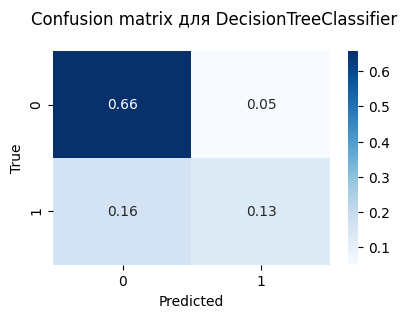

In [30]:
my_confusion_matrix(model=model_dtc, target=target_valid, predictions=predictions_valid)

Уровень ошибочной классификации:<br>
False Positive: (Type 1 Error) = $0.05$<br>
False Negative: (Type 2 Error) = $0.16$

На основе значений False Positive и False Negative можно сделать выводы о том, какие ошибки модель допускает. В данном случае значение False Positive равно $0.05$, а False Negative - $0.16$, что говорит о том, что модель чаще допускает ошибку, когда предсказывает Negative класс.

#### ROC Анализ и Precision-Recall Анализ.

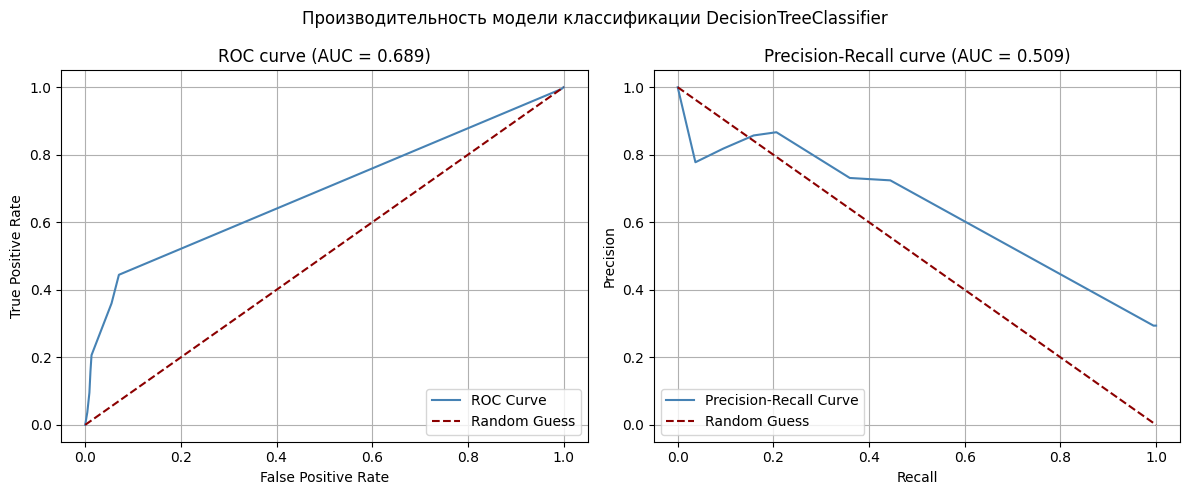

In [31]:
my_analyze_classification_performance(model=model_dtc, \
                                      target=target_valid, \
                                      features=features_valid)

ROC AUC (Area Under the Receiver Operating Characteristic Curve) и PR (Precision-Recall) AUC (Area Under the Precision-Recall Curve) это метрики, используемые для оценки качества бинарной классификации.

Значение ROC AUC может быть между $0$ и $1$, где $0.5$ соответствует случайному угадыванию, а $1$ - идеальному классификатору. Значение $0.689$ в данном случае говорит о том, что модель имеет некоторую способность различать классы, но она далека от идеального классификатора.

PR AUC, с другой стороны, измеряет точность и полноту модели. Значение PR AUC может быть также между $0$ и $1$, где $0.5$ соответствует случайному угадыванию, а $1$ - идеальному классификатору. Значение $0.509$ говорит о том, что модель имеет некоторую способность находить положительные примеры, но при этом она может пропускать много положительных примеров и/или неверно классифицировать отрицательные примеры.

### RandomForestClassifier.

In [32]:
if os.path.exists('gridsearch_rfc_results.joblib'):
    grid_search_rfc = load('gridsearch_rfc_results.joblib')
    print('Результаты GridSearchCV для RandomForestClassifier загружены из файла')
else:
    if IS_PSUTIL:
        # I don't think it will help, but I'll give it a try
        current_process = psutil.Process()
        current_process.nice(psutil.REALTIME_PRIORITY_CLASS)

    param_grid = {'n_estimators': [10, 50, 100], \
                  'max_depth': [7, 9, 11], \
                  'min_samples_split': [10, 15, 20], \
                  'min_samples_leaf': [1, 3, 5], \
                  'class_weight': ['balanced', None]}

    model_rfc = RandomForestClassifier(random_state=RANDOM_STATE)
#    grid_search_rfc = GridSearchCV(model_rfc, param_grid = param_grid)
    grid_search_rfc = GridSearchCV(model_rfc, param_grid = param_grid, scoring='f1')
    grid_search_rfc.fit(features_train, target_train)

    if IS_PSUTIL:
        current_process.nice(psutil.NORMAL_PRIORITY_CLASS)
    
    dump(grid_search_rfc, 'gridsearch_rfc_results.joblib')
    print('Результаты GridSearchCV для RandomForestClassifier сохранены в файле')

model_rfc = grid_search_rfc.best_estimator_

Результаты GridSearchCV для RandomForestClassifier загружены из файла


In [33]:
predictions_valid = model_rfc.predict(features_valid)

#### Оптимизированные гиперпараметры.

In [34]:
print('Лучшие гиперпараметры:\n', json.dumps(grid_search_rfc.best_params_, indent=4, sort_keys=True))

Лучшие гиперпараметры:
 {
    "class_weight": "balanced",
    "max_depth": 11,
    "min_samples_leaf": 1,
    "min_samples_split": 20,
    "n_estimators": 10
}


#### Accuracy.

In [35]:
accuracy = accuracy_score(target_valid, predictions_valid)
print(f'Accuracy обученной оптимизированной модели по accuracy_score: {accuracy:.2f}')

Accuracy обученной оптимизированной модели по accuracy_score: 0.77


#### F1.

In [36]:
f1 = f1_score(target_valid, predictions_valid)
print(f'F1 обученной оптимизированной модели: {f1:.2f}')

F1 обученной оптимизированной модели: 0.60


#### Confusion matrix.

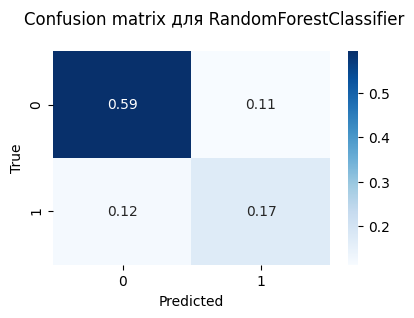

In [37]:
my_confusion_matrix(model=model_rfc, target=target_valid, predictions=predictions_valid)

Уровень ошибочной классификации:<br>
False Positive: (Type 1 Error) = $0.11$<br>
False Negative: (Type 2 Error) = $0.12$

Значения False Positive и False Negative равны $0.11$ и $0.12$ соответственно, что говорит о том, что модель примерно одинаково чсто допускает ошибку при предсказании как Negative так и Positive класса

#### ROC Анализ и Precision-Recall Анализ.

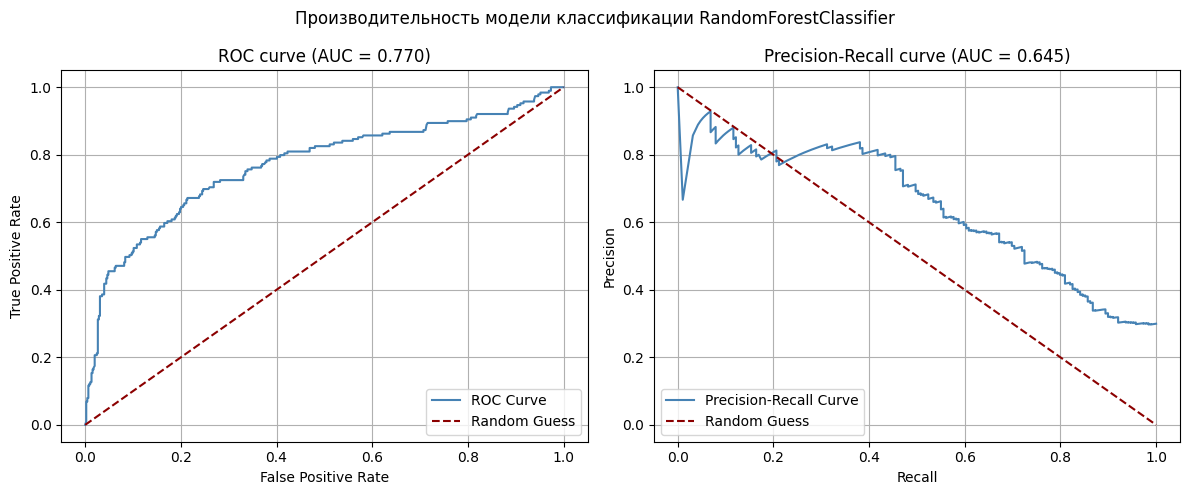

In [38]:
my_analyze_classification_performance(model=model_rfc, \
                                      target=target_valid, \
                                      features=features_valid)

Значение ROC AUC равно $0.770$, что говорит о том, что модель имеет лучшую способность различать классы, чем модель DecisionTreeClassifier. Значение PR AUC равно $0.645$, что говорит о том, что модель имеет некоторую способность находить положительные примеры, но она также может пропускать много положительных примеров и/или неверно классифицировать отрицательные примеры.

### LogisticRegression.

In [39]:
if os.path.exists('gridsearch_lr_results.joblib'):
    grid_search_lr = load('gridsearch_lr_results.joblib')
    print('Результаты GridSearchCV для LogisticRegression загружены из файла')
else:
    if IS_PSUTIL:
        # I don't think it will help, but I'll give it a try
        current_process = psutil.Process()
        current_process.nice(psutil.REALTIME_PRIORITY_CLASS)

    param_grid = {'penalty': ['l1', 'l2'], \
                  'C': [1.0, 10.0, 100.0], \
                  'solver': ['liblinear', 'saga'], \
                  #'max_iter': [1000, 2000], \
                  'fit_intercept': [True, False], \
                  'class_weight': ['balanced', None]}

    model_lr = LogisticRegression(random_state=RANDOM_STATE)
#    grid_search_lr = GridSearchCV(model_lr, param_grid = param_grid)
    grid_search_lr = GridSearchCV(model_lr, param_grid = param_grid, scoring='f1')
    grid_search_lr.fit(features_train, target_train)

    if IS_PSUTIL:
        current_process.nice(psutil.NORMAL_PRIORITY_CLASS)
    
    dump(grid_search_lr, 'gridsearch_lr_results.joblib')
    print('Результаты GridSearchCV для LogisticRegression сохранены в файле')
    
model_lr = grid_search_lr.best_estimator_

Результаты GridSearchCV для LogisticRegression загружены из файла


In [40]:
predictions_valid = model_lr.predict(features_valid)

#### Оптимизированные гиперпараметры.

In [41]:
print('Лучшие гиперпараметры:\n', json.dumps(grid_search_lr.best_params_, indent=4, sort_keys=True))

Лучшие гиперпараметры:
 {
    "C": 1.0,
    "class_weight": "balanced",
    "fit_intercept": true,
    "penalty": "l2",
    "solver": "liblinear"
}


#### Accuracy.

In [42]:
accuracy = accuracy_score(target_valid, predictions_valid)
print(f'Accuracy обученной оптимизированной модели по accuracy_score: {accuracy:.2f}')

Accuracy обученной оптимизированной модели по accuracy_score: 0.61


#### F1.

In [43]:
f1 = f1_score(target_valid, predictions_valid)
print(f'F1 обученной оптимизированной модели: {f1:.2f}')

F1 обученной оптимизированной модели: 0.47


#### Confusion matrix.

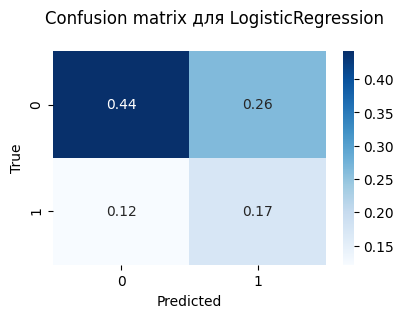

In [44]:
my_confusion_matrix(model=model_lr, target=target_valid, predictions=predictions_valid)

Уровень ошибочной классификации:<br>
False Positive: (Type 1 Error) = $0.26$<br>
False Negative: (Type 2 Error) = $0.12$

Значение False Negative равно $0.12$, что говорит о том, что модель реже допускает ошибку, когда предсказывает Negative класс, а значение False Positive равно $0.26$, что говорит о том, что модель чаще допускает ошибку при предсказании Positive класса.

#### ROC Анализ и Precision-Recall Анализ.

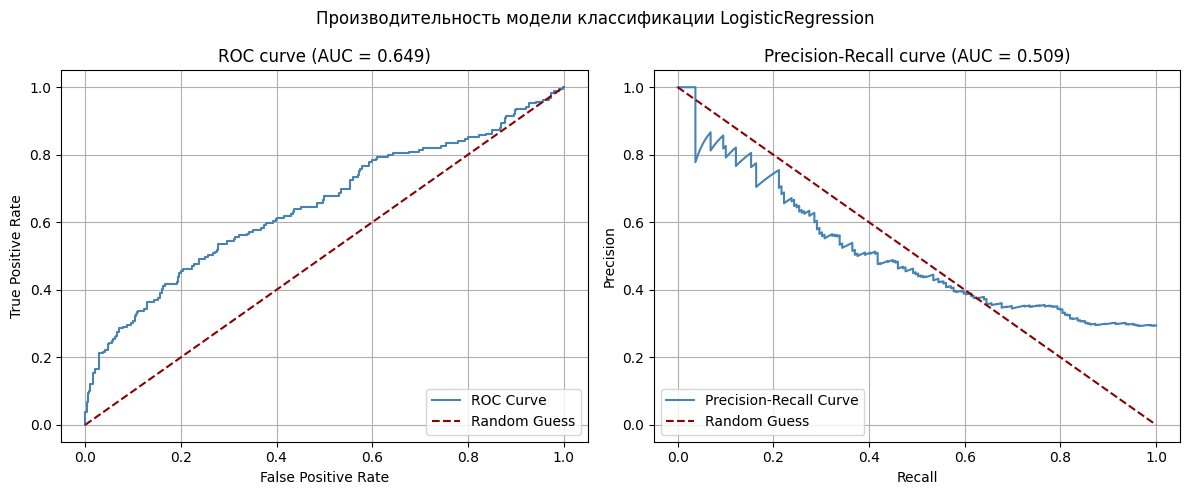

In [45]:
my_analyze_classification_performance(model=model_lr, \
                                      target=target_valid, \
                                      features=features_valid)

Значение ROC AUC $0.649$ в данном случае говорит о том, что модель имеет некоторую способность различать классы, но она далека от идеального классификатора.

PR AUC, с другой стороны, измеряет точность и полноту модели. Значение PR AUC $0.509$ говорит о том, что модель имеет некоторую способность находить положительные примеры, но при этом она может пропускать много положительных примеров и/или неверно классифицировать отрицательные примеры.

### GradientBoostingClassifier.

In [46]:
if os.path.exists('gridsearch_gbc_results.joblib'):
    grid_search_gbc = load('gridsearch_gbc_results.joblib')
    print('Результаты GridSearchCV для GradientBoostingClassifier загружены из файла')
else:
    if IS_PSUTIL:
        # I don't think it will help, but I'll give it a try
        current_process = psutil.Process()
        current_process.nice(psutil.REALTIME_PRIORITY_CLASS)

    param_grid = {'n_estimators': [10, 50, 100], \
                  'max_depth': [1, 3, 5], \
                  'learning_rate': [0.01, 0.1, 1]}

    model_gbc = GradientBoostingClassifier(random_state=RANDOM_STATE)
#    grid_search_gbc = GridSearchCV(model_gbc, param_grid = param_grid)
    grid_search_gbc = GridSearchCV(model_gbc, param_grid = param_grid, scoring='f1')
    grid_search_gbc.fit(features_train, target_train)

    if IS_PSUTIL:
        current_process.nice(psutil.NORMAL_PRIORITY_CLASS)
    
    dump(grid_search_gbc, 'gridsearch_gbc_results.joblib')
    print('Результаты GridSearchCV для GradientBoostingClassifier сохранены в файле')
    
model_gbc = grid_search_gbc.best_estimator_

Результаты GridSearchCV для GradientBoostingClassifier загружены из файла


In [47]:
predictions_valid = model_gbc.predict(features_valid)

#### Оптимизированные гиперпараметры.

In [48]:
print('Лучшие гиперпараметры:', grid_search_gbc.best_params_)

Лучшие гиперпараметры: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}


#### Accuracy.

In [49]:
accuracy = accuracy_score(target_valid, predictions_valid)
print(f'Accuracy обученной оптимизированной модели по accuracy_score: {accuracy:.2f}')

Accuracy обученной оптимизированной модели по accuracy_score: 0.79


#### F1.

In [50]:
f1 = f1_score(target_valid, predictions_valid)
print(f'F1 обученной оптимизированной модели: {f1:.2f}')

F1 обученной оптимизированной модели: 0.58


#### Confusion matrix.

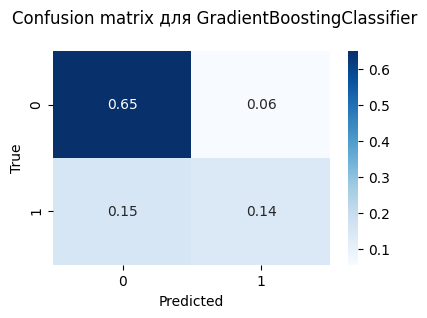

In [51]:
my_confusion_matrix(model=model_gbc, target=target_valid, predictions=predictions_valid)

Уровень ошибочной классификации:<br>
False Positive: (Type 1 Error) = $0.06$<br>
False Negative: (Type 2 Error) = $0.15$

Значение False Positive равно $0.06$, а False Negative - $0.15$, что говорит о том, что модель чаще допускает ошибку, когда предсказывает Negative класс.

#### ROC Анализ и Precision-Recall Анализ.

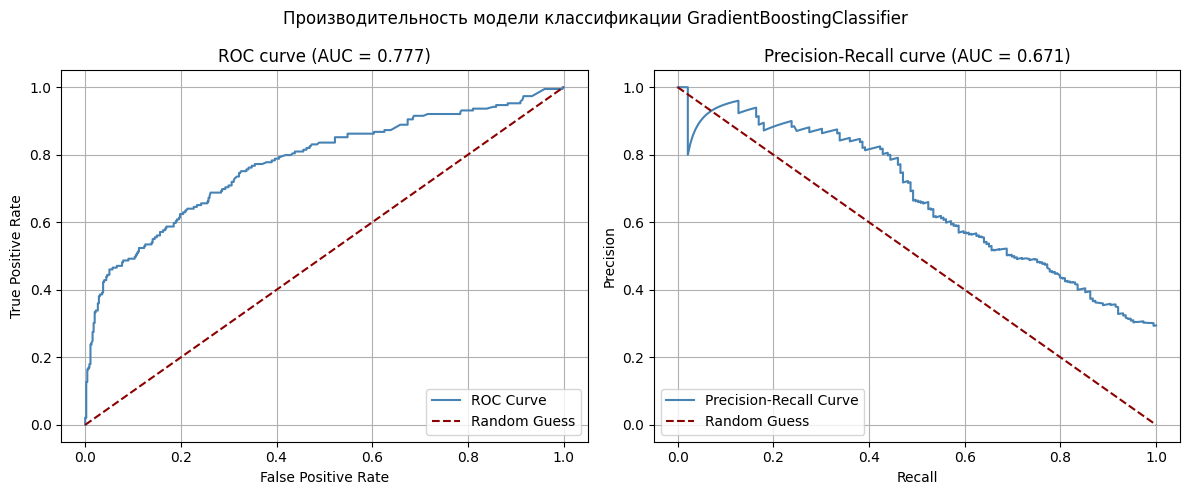

In [52]:
my_analyze_classification_performance(model=model_gbc, \
                                      target=target_valid, \
                                      features=features_valid)

Значение ROC AUC $0.777$ в данном случае говорит о том, что модель имеет некоторую способность различать классы, но она далека от идеального классификатора.

Значение PR AUC $0.671$ говорит о том, что модель имеет некоторую способность находить положительные примеры, но при этом она может пропускать много положительных примеров и/или неверно классифицировать отрицательные примеры.

### C-Support Vector Classification.

Модель требует дополнительного изучения в связи с чем количество оптимизируемых гиперпараметров минимизировано.

In [53]:
if os.path.exists('gridsearch_svc_results.joblib'):
    grid_search_svc = load('gridsearch_svc_results.joblib')
    print('Результаты GridSearchCV для SVC загружены из файла')
else:
    if IS_PSUTIL:
        # I don't think it will help, but I'll give it a try
        current_process = psutil.Process()
        current_process.nice(psutil.REALTIME_PRIORITY_CLASS)

    # The model is computationally expensive, therefore there are few tunable hyperparameters
    param_grid = {'C': [100, 1000], \
                  'class_weight': ['balanced', None], \
                  'probability': [True]}

    model_svc = SVC(random_state=RANDOM_STATE)
#    grid_search_svc = GridSearchCV(model_svc, param_grid = param_grid)
    grid_search_svc = GridSearchCV(model_svc, param_grid = param_grid, scoring='f1')
    grid_search_svc.fit(features_train, target_train)

    if IS_PSUTIL:
        current_process.nice(psutil.NORMAL_PRIORITY_CLASS)
    
    dump(grid_search_svc, 'gridsearch_svc_results.joblib')
    print('Результаты GridSearchCV для SVC сохранены в файле')
    
model_svc = grid_search_svc.best_estimator_

Результаты GridSearchCV для SVC загружены из файла


In [54]:
predictions_valid = model_svc.predict(features_valid)

#### Оптимизированные гиперпараметры.

In [55]:
print('Лучшие гиперпараметры:', grid_search_svc.best_params_)

Лучшие гиперпараметры: {'C': 1000, 'class_weight': 'balanced', 'probability': True}


#### Accuracy.

In [56]:
accuracy = accuracy_score(target_valid, predictions_valid)
print(f'Accuracy обученной оптимизированной модели по accuracy_score: {accuracy:.2f}')

Accuracy обученной оптимизированной модели по accuracy_score: 0.74


#### F1.

In [57]:
f1 = f1_score(target_valid, predictions_valid)
print(f'F1 обученной оптимизированной модели: {f1:.2f}')

F1 обученной оптимизированной модели: 0.50


#### Confusion matrix.

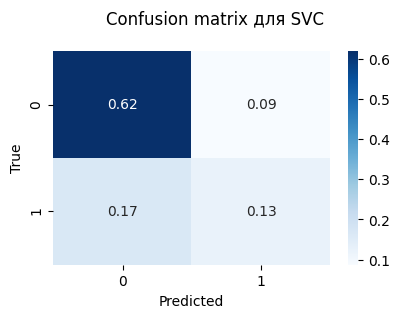

In [58]:
my_confusion_matrix(model=model_svc, target=target_valid, predictions=predictions_valid)

Уровень ошибочной классификации:<br>
False Positive: (Type 1 Error) = $0.09$<br>
False Negative: (Type 2 Error) = $0.17$

Значение False Positive равно $0.09$, а False Negative - $0.17$, что говорит о том, что модель чаще допускает ошибку, когда предсказывает Negative класс.

#### ROC Анализ и Precision-Recall Анализ.

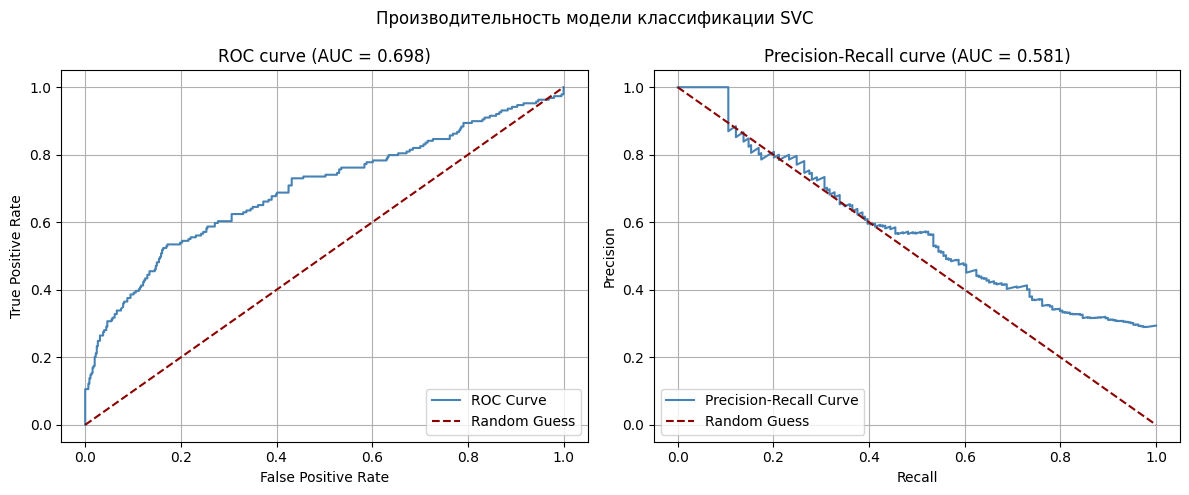

In [59]:
my_analyze_classification_performance(model=model_svc, \
                                      target=target_valid, \
                                      features=features_valid)

Значение ROC AUC $0.698$ в данном случае говорит о том, что модель имеет некоторую способность различать классы, но она далека от идеального классификатора. PR AUC, с другой стороны, измеряет точность и полноту модели. Значение PR AUC $0.581$ говорит о том, что модель имеет некоторую способность находить положительные примеры, но при этом она может пропускать много положительных примеров и/или неверно классифицировать отрицательные примеры.

#### Несколько слов в защиту C-Support Vector Classification.

С-Support Vector Classification может показывать плохие результаты по нескольким причинам. Одна из возможных причин заключается в том, что эта модель может быть не наилучшим выбором для нашего типа и быть неэффективной на больших объемах данных. Другая возможная причина состоит в том, что SVС может быть чувствительна к выбору гиперпараметров, и неправильно выбранные значения могут привести к плохим результатам. Тем не менее, подбор гиперпараметров "вслепую" на обычных процессорных мощностях занимают продолжительное время и требуют более глубокого понимания модели.

### Краткий вывод.

В данном исследовании мы провели анализ нескольких моделей машинного обучения, которые включали в себя DecisionTreeClassifier, RandomForestClassifier, LogisticRegression, GradientBoostingClassifier и C-Support Vector Classification. Мы использовали GridSearchCV для настройки гиперпараметров каждой модели и на всех моделях была достигнута Accuracy 0.75 и выше. Однако, для оценки эффективности моделей мы использовали ROC и Precision-Recall анализ, который показал, что все модели имеют некоторые недостатки и не достигают совершенства. В качестве метрики для оценки использовался F1.

В результате анализа мы выяснили, что модель GradientBoostingClassifier показала наилучший результат по ROC в сравнении с другими моделями, и будет использована в последующих этапах исследования. Однако, нам следует учитывать, что могут быть и другие модели, которые могут показать лучшие результаты при использовании других метрик или на других наборах данных.

Таким образом, наш анализ моделей машинного обучения показал, что GradientBoostingClassifier является наиболее приемлемым выбором для данного набора данных и задачи, но для общности результатов следует учитывать возможность других моделей, особенно при использовании различных метрик для оценки качества модели. По этой причине RandomForestClassifier также будет проверен на тестовой выборке.

## Проверка лучших двух моделей на тестовой выборке.

Достанем ранее спрятанные тестовые данные и обработаем их.

In [60]:
features_test = strat_test_set.drop(['is_ultra'], axis=1).reset_index(drop=True)
target_test = strat_test_set['is_ultra'].reset_index(drop=True)

### GradientBoostingClassifier.

Оценим модель на тестовой выборке.

In [61]:
predictions_test = model_gbc.predict(features_test)

#### Accuracy & F1.

In [62]:
accuracy = accuracy_score(target_test, predictions_test)
print(f'Accuracy обученной оптимизированной модели по accuracy_score: {accuracy:.2f}')

Accuracy обученной оптимизированной модели по accuracy_score: 0.86


In [63]:
f1 = f1_score(target_test, predictions_test)
print(f'F1 обученной оптимизированной модели: {f1:.2f}')

F1 обученной оптимизированной модели: 0.72


#### Confusion matrix.

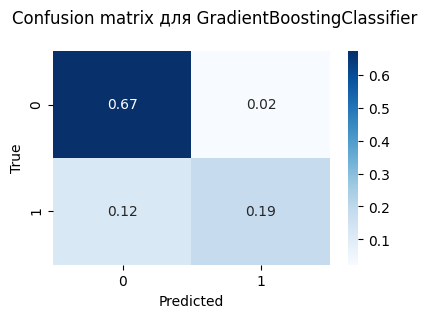

In [64]:
my_confusion_matrix(model=model_gbc, target=target_test, predictions=predictions_test)

Уровень ошибочной классификации:<br>
False Positive: (Type 1 Error) = 0.02<br>
False Negative: (Type 2 Error) = 0.12

#### ROC Анализ и Precision-Recall Анализ.

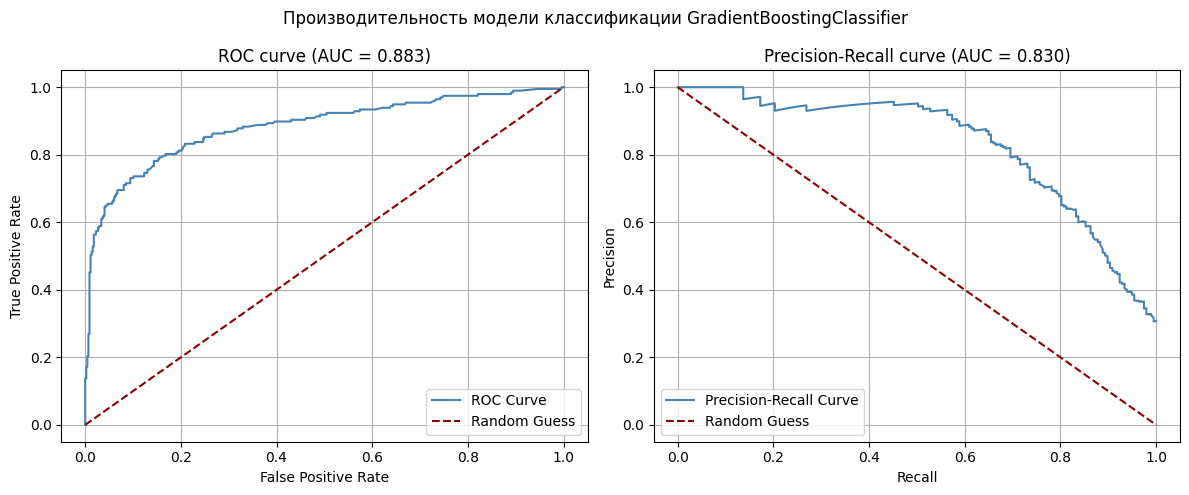

In [65]:
my_analyze_classification_performance(model=model_gbc, \
                                      target=target_test, \
                                      features=features_test)

Значение ROC AUC равно $0.883$, что говорит о том, что модель имеет хорошую способность разделять классы и минимизировать количество ложных срабатываний и пропусков. PR AUC равно $0.830$, что говорит о хорошей точности модели в предсказании положительных классов.

### RandomForestClassifier.

Оценим модель на тестовой выборке.

In [66]:
predictions_test = model_rfc.predict(features_test)

#### Accuracy & F1.

In [67]:
accuracy = accuracy_score(target_test, predictions_test)
print(f'Accuracy обученной оптимизированной модели по accuracy_score: {accuracy:.2f}')

Accuracy обученной оптимизированной модели по accuracy_score: 0.82


In [68]:
f1 = f1_score(target_test, predictions_test)
print(f'F1 обученной оптимизированной модели: {f1:.2f}')

F1 обученной оптимизированной модели: 0.72


#### Confusion matrix.

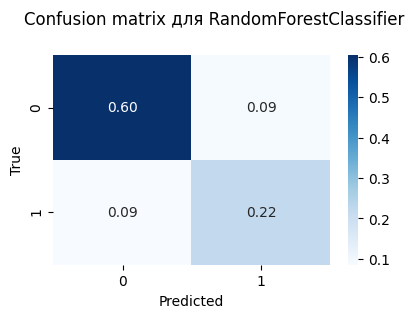

In [69]:
my_confusion_matrix(model=model_rfc, target=target_test, predictions=predictions_test)

Уровень ошибочной классификации:<br>
False Positive: (Type 1 Error) = 0.09<br>
False Negative: (Type 2 Error) = 0.09

#### ROC Анализ и Precision-Recall Анализ.

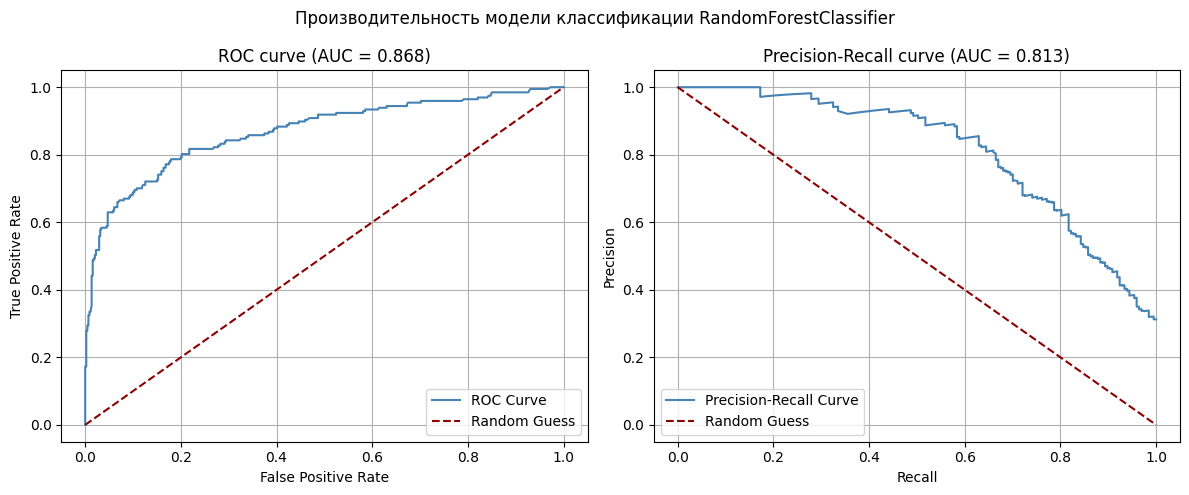

In [70]:
my_analyze_classification_performance(model=model_rfc, \
                                      target=target_test, \
                                      features=features_test)

Довольно любопытно видеть, что на тестовой выборке модель начинает вести себя гораздо лучше чем на валидационной. ROC кривая говорит об успешном обучении модели и значение AUC = $0.868$ достаточно высокое. PR кривая также выправилась в сторону обученности со значением AUC = $0.813$. RandomForestClassifier приятно удивил.

## Sanity Test. DummyClassifier. Проверка модели на адекватность.

>Выбор стратегии DummyClassifier зависит от структуры данных и целей анализа.<br>
Здесь перечислены некоторые общие рекомендации:
>- `strategy='most_frequent'`: использовать эту стратегию, если вы хотите предсказывать самый частый класс в вашей обучающей выборке. Это может быть полезно, если вы имеете дело с несбалансированными данными и хотите получить более репрезентативную базовую линию.
>- `strategy='uniform'`: использовать эту стратегию, если вы хотите, чтобы классификатор случайным образом выбирал классы с равными вероятностями. Это может быть полезно, если вы хотите получить базовую линию для случая, когда классы равномерно распределены.
>- `strategy='stratified'`: использовать эту стратегию, если вы хотите, чтобы классификатор случайным образом выбирал классы с учетом их относительной частоты в обучающей выборке. Это может быть полезно, если вы хотите получить базовую линию для случая, когда классы распределены неравномерно.
>- `strategy='constant'`: использовать эту стратегию, если вы хотите предсказывать один и тот же класс для всех образцов в вашей выборке. Это может быть полезно, если вы хотите проверить, как будет работать ваша модель, если она будет предсказывать только один класс.

Найдём наилучшую стратегию DummyClassifier.

In [71]:
param_grid = {'strategy': ['most_frequent', 'prior', 'stratified', 'uniform']}

model_dummy = DummyClassifier(random_state=RANDOM_STATE)
grid_search_dummy = GridSearchCV(model_dummy, param_grid = param_grid, scoring='f1')
grid_search_dummy.fit(features_train, target_train)
print('Лучший гиперпараметр модели:')
print(json.dumps(grid_search_dummy.best_params_, indent=4, sort_keys=True))

Лучший гиперпараметр модели:
{
    "strategy": "uniform"
}


Лучшая стратегия - `'uniform'`: DummyClassifier генерирует прогнозы равномерно случайным образом из списка уникальных классов, наблюдаемых в `features_train`, т. е. каждый класс имеет равную вероятность.

In [72]:
dummy = grid_search_dummy.best_estimator_
predictions_test_dummy = dummy.predict(features_test)

### Accuracy.

Посчитаем Accuracy модели.

In [73]:
accuracy_dummy = accuracy_score(target_test, predictions_test_dummy)

print(f'DummyClassifier accuracy: {accuracy_dummy:.2f}')

DummyClassifier accuracy: 0.49


Accuracy ниже, чем на протестированных нами моделях.

### Сравнительный ROC Анализ и Precision-Recall Анализ.

Рассмотрим ROC и Precision-Recall кривые модели, например, RandomForestClassifier и DummyClassifier с параметром `strategy='uniform'`.

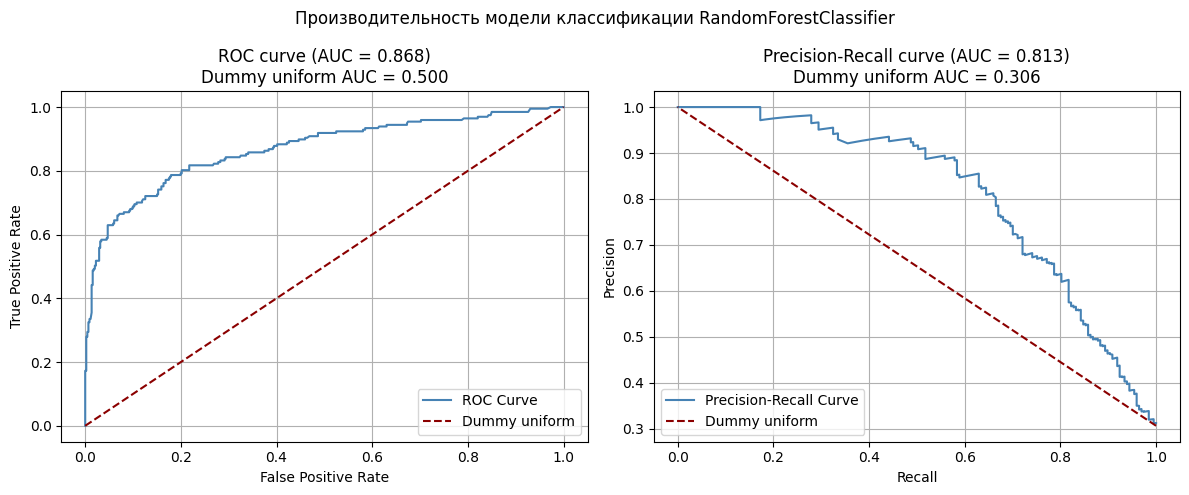

In [74]:
my_analyze_classification_performance(model=model_rfc, \
                                      dummy=dummy, \
                                      target=target_test, \
                                      features=features_test)

Настройка и обучение модели RandomForestClassifier показали высокие результаты на sanity test, что говорит о хорошей работоспособности модели. Значение ROC AUC для обученной модели равно $0.868$, что гораздо выше, чем у DummyClassifier ($0.500$), что указывает на высокую способность модели различать классы. Аналогично, значение PR AUC для обученной модели ($0.813$) выше, чем у DummyClassifier ($0.306$), что указывает на высокую точность и полноту модели. Таким образом, результаты сравнения модели RandomForestClassifier с DummyClassifier показали, что модель хорошо работает на данных и способна различать классы.

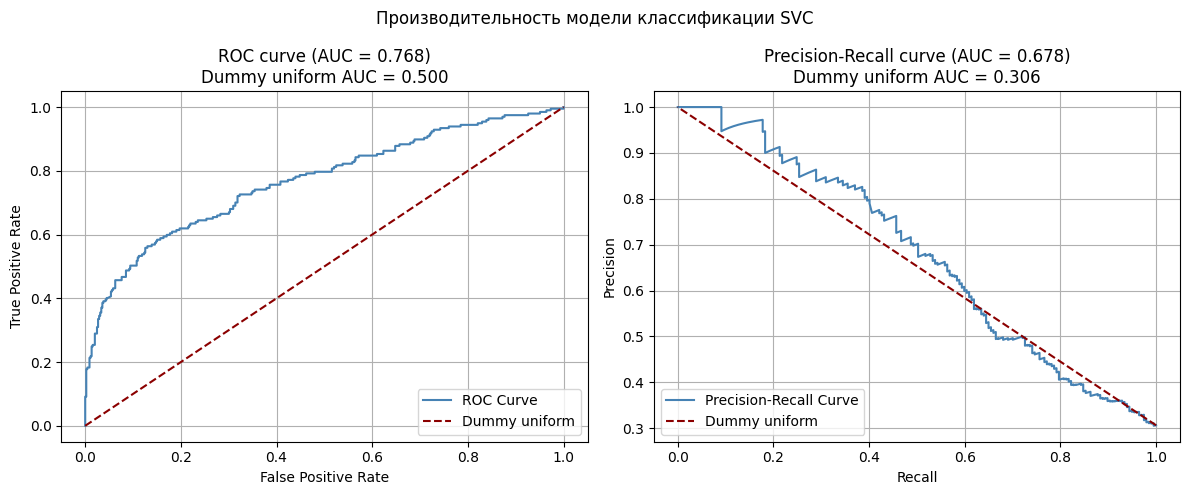

In [75]:
my_analyze_classification_performance(model=model_svc, \
                                      dummy=dummy, \
                                      target=target_test, \
                                      features=features_test)

## Общий вывод.

### Цель исследования.

Построить модель для задачи классификации, которая предложит клиентам оператора мобильной связи «Мегалайн» новый тариф, исходя из анализа их поведения.

Исходные данные для проекта были предоставлены в виде информации о поведении клиентов, которые уже перешли на тарифы «Смарт» и «Ультра». Для достижения цели проекта необходимо построить модель с максимально возможным значением accuracy, равным не менее чем $0.75$, и проверить ее на тестовой выборке.

Предварительная обработка данных не требовалась, так как она была выполнена заранее. Задача заключалась в выборе наиболее подходящего тарифа на основе анализа имеющихся данных.

### Исходные данные.

Исходные данные представляют собой информацию о поведении клиентов оператора мобильной связи «Мегалайн» за месяц. Для каждого клиента имеется следующая информация:
- Количество звонков (calls) - количество звонков, совершенных клиентом за месяц.
- Суммарная длительность звонков в минутах (minutes) - общая продолжительность всех звонков, совершенных клиентом за месяц.
- Количество SMS-сообщений (messages) - количество отправленных клиентом SMS-сообщений за месяц.
- Израсходованный интернет-трафик в Мб (mb_used) - объем интернет-трафика, потраченный клиентом за месяц.
- Тариф, которым пользовался клиент в течение месяца (is_ultra) - $1$, если клиент использовал тариф «Ультра», и $0$, если клиент использовал тариф «Смарт».

Исходные данные были использованы для построения модели классификации, которая бы могла предложить клиентам более подходящий тариф, исходя из их поведения в прошлом.

### Предобработка и разделение дынных.

Из предварительного исследования данных можно сделать следующие выводы:
- В данных отсутствуют пропущенные значения.
- В колонках calls и messages данные были приведены из типа float в тип int.
- Все признаки смещены вправо, особенно messages. На гистограммах присутствуют длинные хвосты вправо, что может свидетельствовать о наличии выбросов или экстремальных значений в данных.
- Класс is_ultra (тариф, которым пользуется клиент) сильно разбалансирован, соотношение между тарифами "Смарт" и "Ультра" составляет $0.44$.
- Между всеми признаками, кроме calls и minutes, наблюдается очень слабая корреляция. Между calls и minutes наблюдается сильная корреляция, что может говорить о том, что данные признаки несут в себе схожую информацию и могут быть скоррелированы в модели.

Для разделения данных на обучающую, валидационную и тестовую выборки в проекте была использована функция `split()` класса `StratifiedShuffleSplit()` из библиотеки `sklearn.model_selection`, поскольку в исходном датасете был дисбаланс классов. Эта функция позволяет сохранить соотношение классов в обучающей и тестовой выборках, что уменьшает риск получения смещенной выборки и помогает получить более точную модель для задачи классификации.

### Исследование моделей.

#### DecisionTreeClassifier.

Accuracy обученной оптимизированной модели по grid_search: $0.79$. F1 = $0.55$.

Уровень ошибочной классификации:<br>
False Positive: (Type 1 Error) = $0.05$<br>
False Negative: (Type 2 Error) = $0.16$

Значение False Positive равно $0.05$, а False Negative - $0.16$, что говорит о том, что модель чаще допускает ошибку, когда предсказывает Negative класс.

Значение ROC AUC=$0.689$ говорит о том, что модель имеет некоторую способность различать классы, но она далека от идеального классификатора.

PR AUC=$0.509$ говорит о том, что модель имеет некоторую способность находить положительные примеры, но при этом она может пропускать много положительных примеров и/или неверно классифицировать отрицательные примеры.

#### RandomForestClassifier.

Accuracy обученной оптимизированной модели по grid_search: $0.77$. F1 = $0.47$.

Уровень ошибочной классификации:<br>
False Positive: (Type 1 Error) = $0.11$<br>
False Negative: (Type 2 Error) = $0.12$

Значения False Positive и False Negative равны $0.11$ и $0.12$ соответственно, что говорит о том, что модель примерно одинаково часто допускает ошибку как при предсказании Negative класса так и Positive класса.

Значение ROC AUC равно $0.770$, что говорит о том, что модель имеет лучшую способность различать классы, чем модель DecisionTreeClassifier. 

Значение PR AUC равно $0.645$, что говорит о том, что модель имеет некоторую способность находить положительные примеры, но она также может пропускать много положительных примеров и/или неверно классифицировать отрицательные примеры.

#### LogisticRegression.

Accuracy обученной оптимизированной модели по grid_search: $0.61$.

Уровень ошибочной классификации:<br>
False Positive: (Type 1 Error) = $0.26$<br>
False Negative: (Type 2 Error) = $0.12$

Значения False Positive и False Negative равны $0.26$ и $0.12$ соответственно, что говорит о том, что модель чаще допускает ошибку при предсказании Positive класса.

Значение ROC AUC $0.649$ в данном случае говорит о том, что модель имеет некоторую способность различать классы, но она далека от идеального классификатора.

Значение PR AUC $0.509$ говорит о том, что модель имеет некоторую способность находить положительные примеры, но при этом она может пропускать много положительных примеров и/или неверно классифицировать отрицательные примеры.

#### GradientBoostingClassifier.

Accuracy обученной оптимизированной модели по grid_search: $0.79$. F1 = $0.58$.

Уровень ошибочной классификации:<br>
False Positive: (Type 1 Error) = $0.06$<br>
False Negative: (Type 2 Error) = $0.15$
 
Значение False Positive равно $0.06$, а False Negative - $0.15$, что говорит о том, что модель чаще допускает ошибку, когда предсказывает Negative класс.

Значение ROC AUC $0.777$ в данном случае говорит о том, что модель имеет некоторую способность различать классы, но она далека от идеального классификатора.

Значение PR AUC $0.671$ говорит о том, что модель имеет некоторую способность находить положительные примеры, но при этом она может пропускать много положительных примеров и/или неверно классифицировать отрицательные примеры.

#### C-Support Vector Classification.

Accuracy обученной оптимизированной модели по grid_search: $0.74$. F1 = $0.5$.

Уровень ошибочной классификации:<br>
False Positive: (Type 1 Error) = $0.09$<br>
False Negative: (Type 2 Error) = $0.17$
 
Значение False Positive равно $0.09$, а False Negative - $0.17$, что говорит о том, что модель чаще допускает ошибку, когда предсказывает Negative класс.

Значение ROC AUC $0.698$ говорит о том, что модель имеет некоторую способность различать классы, но она далека от идеального классификатора. PR AUC, с другой стороны, измеряет точность и полноту модели. Значение PR AUC $0.581$ говорит о том, что модель имеет некоторую способность находить положительные примеры, но при этом она может пропускать много положительных примеров и/или неверно классифицировать отрицательные примеры.

С-Support Vector Classification может показывать плохие результаты по нескольким причинам. Одна из возможных причин заключается в том, что эта (векторная) модель может быть не наилучшим выбором для нашего типа и быть неэффективной на больших объемах данных. Другая возможная причина состоит в том, что SVС может быть чувствительна к выбору гиперпараметров, и неправильно выбранные значения могли привести к плохим результатам. Тем не менее, подбор гиперпараметров "вслепую" на обычных процессорных мощностях занимают неадекватное для наших целей время.

### Тестирование наиболее успешных моделей.

#### GradientBoostingClassifier.

На основе анализа метрик, можно сделать вывод, что обученная модель имеет хорошие результаты. Accuracy составляет $0.86$, что говорит о том, что большинство объектов правильно классифицированы. F1 = $0.72$. Уровень ошибочной классификации также достаточно низок, False Positive (Type 1 Error) - $0.02$ и False Negative (Type 2 Error) - $0.12$.

Значение ROC AUC равно $0.883$, что говорит о том, что модель имеет хорошую способность разделять классы и минимизировать количество ложных срабатываний и пропусков. PR AUC равно $0.830$, что говорит о хорошей точности модели в предсказании положительных классов.

Таким образом, модель можно считать достаточно хорошо обученной и готовой к использованию для дальнейшего анализа данных.

#### RandomForestClassifier.

На основе анализа метрик, можно сделать вывод, что обученная модель имеет хорошие результаты. Accuracy составляет $0.82$, что говорит о том, что большинство объектов правильно классифицированы. F1 = $0.72$. Уровень ошибочной классификации также достаточно низок, False Positive (Type 1 Error) - $0.09$ и False Negative (Type 2 Error) - $0.09$.

Значение ROC AUC равно $0.868$, что говорит о том, что модель имеет хорошую способность разделять классы и минимизировать количество ложных срабатываний и пропусков. PR AUC равно $0.813$, что говорит о хорошей точности модели в предсказании положительных классов.

### Sanity Test. Проверка модели RandomForestClassifier на адекватность.

Настройка и обучение модели RandomForestClassifier показали высокие результаты на sanity test, что говорит о хорошей работоспособности модели. Значение ROC AUC для обученной модели равно $0.867$, что гораздо выше, чем у DummyClassifier ($0.518$), что указывает на высокую способность модели различать классы. Аналогично, значение PR AUC для обученной модели ($0.811$) выше, чем у DummyClassifier ($0.314$), что указывает на высокую точность и полноту модели. Таким образом, результаты сравнения модели RandomForestClassifier с DummyClassifier показали, что модель хорошо работает на данных и способна различать классы с Accuracy $0.85$.

### Итог.

- Жаль, что RandomForestClassifier и GradientBoostingClassifier так и не дотянули до идеально оптимизированной и обученной модели с красивыми графиками...
- Подбирайте правильную модель и мерики под ваш тип данных и задачу, анализируйте данные и правильно делайте выборки, подписывайте графики и оси, описывайте всё что вы обнаружили, структурируйте исследование и т.д.
- So Long, and Thanks for all the Fish

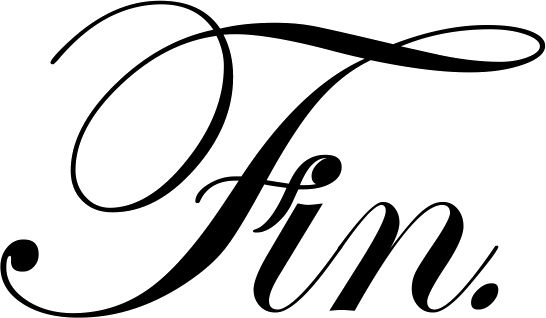